# Quatnum classification

In [1]:
#import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from sklearn.utils import shuffle

from quantum_classification import *

<font size="3">
In this notebook, we see the dependence of trainability of the QML classifier on the circuit structure and the cost function.

The circuit structure is defined by three parts: embedding part, ansatz part.
- embedding part: the embedding circuit to encode input data into the quantum circuit. 
    There are 3 types of embedding circuits:
    - Tensor Product Embedding (TPE): embedding circuit is a tensor product of rotation gates (Input data as angles).
    - Hardware Efficient Embedding (HEE): embedding circuit is a tensor product of rotation gates (Input data as angles) followed by controlled-NOT gates over adjacent qubits.
    - Classically Hard Embedding (CHE): embedding circuit that is hard to simulate on classically.
- ansatz part: the parametrized circuit to learn the training dataset.
    There are 3 types of ansatz circuits:
    - Tensor Product Ansatz (TPA): ansatz circuit is a tensor product of rotation gates (Input data as angles).
    - Hardware Efficient Ansatz (HEA): ansatz circuit is a tensor product of rotation gates (Input data as angles) followed by controlled-NOT gates over adjacent qubits.
    - Strongly Entangling Ansatz (SEA): ansatz circuit that is strongly entangled.

On `HEE` and `CHE`, refer to [`Subtleties in the trainability of quantum machine learning models`](https://arxiv.org/abs/2110.14753) for more details.

On `SEA`, refer to PennyLnae page: [embedding and ansatz](https://pennylane.readthedocs.io/en/stable/introduction/templates.html)
</font>

## 1. Train OR data

In [2]:
# OR
x_train = np.array([[0,0], [0,1], [1,0], [1,1]])
y_train = np.array([0, 1, 1, 1])
x_test, y_test = x_train, y_train

### test

In [3]:
# settings
nqubits = 2; nlayers = 2; embedding_type = 'APE'; ansatz_type = 'SEA'; cost_type = 'MSE'
label = f'{embedding_type}, {ansatz_type}'

# optimize
test = quantum_classifier(x_train, y_train, nqubits, nlayers, embedding_type, ansatz_type, cost_type, shots=None, stepsize=0.3, steps=200)

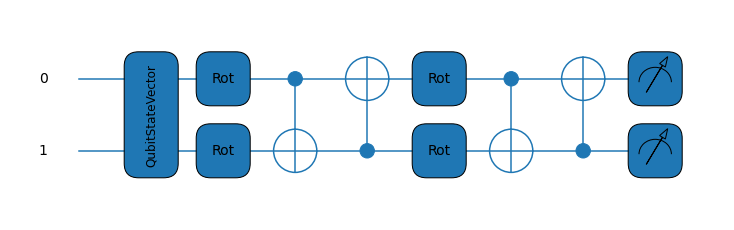

In [4]:
test.draw_circuit()

In [5]:
test.optimize()

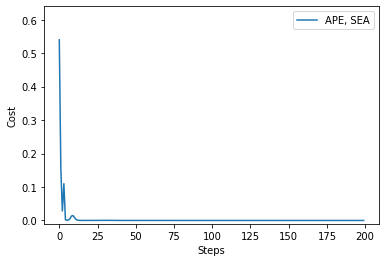

In [6]:
test.plot_cost()

In [7]:
print('accuracy ', test.accuracy(x_test, y_test))
print('optimized cost; ', test.cost_list[-1])

accuracy  1.0
optimized cost;  2.79818180769767e-06


## dependence of trainability on the types of embedding, ansatz and cost function

In [2]:
def train_each_circuit(x_train, y_train, x_test, y_test, nqubits, nlayers_list, embedding_list, ansatz_list, cost_type, draw=False, shots=None, stepsize=0.3, steps=50):
    optimized_cost_acc = []
    cost_all = []
    for nlayers in nlayers_list:
        for embedding_type in embedding_list:
            cost_embedding = []
            for ansatz_type in ansatz_list:
                label = f'{embedding_type}, {ansatz_type}'
                print(label)

                opt_circuit = quantum_classifier(x_train, y_train, nqubits, nlayers, embedding_type, ansatz_type, cost_type, shots, stepsize, steps)

                if draw:
                    opt_circuit.draw_circuit()
                else:
                    pass
                
                opt_circuit.optimize()

                cost_embedding.append((label, opt_circuit.cost_list))

                acc = opt_circuit.accuracy(x_test, y_test)
                cost_ = float(opt_circuit.cost_list[-1])
                optimized_cost_acc.append((f'embedding_type: {embedding_type}, ansatz_type: {ansatz_type}', cost_, acc))
            
            cost_all.append(cost_embedding)
    return optimized_cost_acc, cost_all

def sort_cost_acc(optimized_cost_acc):
    optimized_cost = [(x[0], x[1]) for x in optimized_cost_acc]
    optimized_acc = [(x[0], x[2]) for x in optimized_cost_acc]
    optimized_cost = dict(sorted(dict(optimized_cost).items(), key=lambda item: item[1]))
    optimized_acc = dict(sorted(dict(optimized_acc).items(), key=lambda item: item[1], reverse=True))

    print(cost_type)
    for key, value in optimized_cost.items():
        print(f'{key}: cost {value}')

    print('---------------------------------------------------------------')
    for key, value in optimized_acc.items():
        print(f'{key}: accuracy {value}')

def plot_cost(cost_all):
    plt.figure(figsize=(10, 6))
    for i, cost_embedding in enumerate(cost_all):
        ax = plt.subplot(2,2,i+1)
        for (label, cost_list) in cost_embedding:
            ax.plot(cost_list, label=label)
        ax.set_xlabel('Steps')
        ax.set_ylabel('Cost')
        #ax.set_ylim(0, 1.)
        ax.legend()
    plt.show()

### when cost_type is mse

In [22]:
nqubits = 2; nlayers_list = [2]; cost_type = 'MSE'
embedding_list = ['TPE', 'HEE', 'CHE', 'APE']
ansatz_list = ['TPA', 'HEA', 'SEA']
draw = False; shots = None; stepsize = 0.3; steps = 300

optimized_cost_acc_mse, cost_all_mse = train_each_circuit(x_train, y_train, x_test, y_test, nqubits, nlayers_list, embedding_list, ansatz_list, cost_type, draw, shots, stepsize, steps)

TPE, TPA
TPE, HEA
TPE, SEA
HEE, TPA
HEE, HEA
HEE, SEA
CHE, TPA
CHE, HEA
CHE, SEA
APE, TPA
APE, HEA
APE, SEA


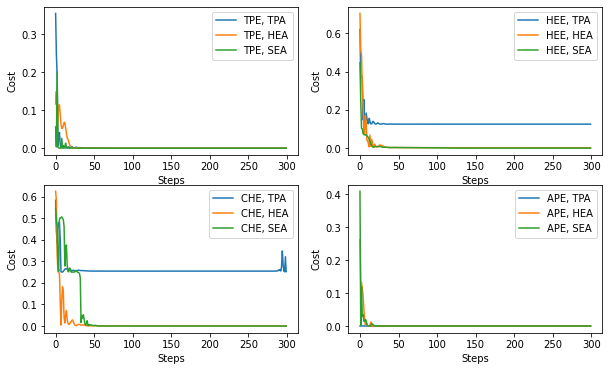

In [23]:
plot_cost(cost_all_mse)

`TPE` and `APE` seems stablly train the parameters.

In `Subtleties in the trainability of quantum machine learning models`
> Particularly, we here show that the CHE scheme can lead to poor performance for some standard benchmarking test.

In [69]:
sort_cost_acc(optimized_cost_acc_mse)

MSE
embedding_type: APE, ansatz_type: HEA: cost 2.94096416977497e-07
embedding_type: TPE, ansatz_type: SEA: cost 1.955301323737173e-06
embedding_type: APE, ansatz_type: SEA: cost 2.3997328347325094e-06
embedding_type: HEE, ansatz_type: SEA: cost 2.4956728669255268e-06
embedding_type: CHE, ansatz_type: SEA: cost 3.5095095653164565e-06
embedding_type: TPE, ansatz_type: TPA: cost 4.293192503641198e-05
embedding_type: TPE, ansatz_type: HEA: cost 0.00035442613369657147
embedding_type: CHE, ansatz_type: HEA: cost 0.0020206765953009777
embedding_type: APE, ansatz_type: TPA: cost 0.004693456650152924
embedding_type: HEE, ansatz_type: TPA: cost 0.12500239744165043
embedding_type: CHE, ansatz_type: TPA: cost 0.25000894906596555
embedding_type: HEE, ansatz_type: HEA: cost 0.29073068116212863
---------------------------------------------------------------
embedding_type: TPE, ansatz_type: TPA: accuracy 1.0
embedding_type: TPE, ansatz_type: HEA: accuracy 1.0
embedding_type: TPE, ansatz_type: SEA: a

### when cost_type is cross entropy

In [70]:
nqubits = 2; nlayers_list = [2]; cost_type = 'LOG'
embedding_list = ['TPE', 'HEE', 'CHE', 'APE']
ansatz_list = ['TPA', 'HEA', 'SEA']
draw = False; shots = None; stepsize = 0.3; steps = 300

optimized_cost_acc_log, cost_all_log = train_each_circuit(x_train, y_train, x_test, y_test, nqubits, nlayers_list, embedding_list, ansatz_list, cost_type, draw, shots, stepsize, steps)

TPE, TPA
TPE, HEA
TPE, SEA
HEE, TPA
HEE, HEA
HEE, SEA
CHE, TPA
CHE, HEA
CHE, SEA
APE, TPA
APE, HEA
APE, SEA


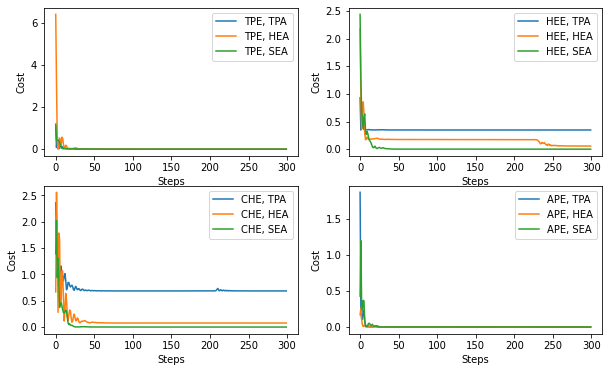

In [71]:
plot_cost(cost_all_log)

In [72]:
sort_cost_acc(optimized_cost_acc_log)

LOG
embedding_type: APE, ansatz_type: HEA: cost 2.5734280464509664e-05
embedding_type: APE, ansatz_type: SEA: cost 5.467147350708096e-05
embedding_type: TPE, ansatz_type: SEA: cost 0.0005669660386509214
embedding_type: HEE, ansatz_type: SEA: cost 0.0007063131927517226
embedding_type: TPE, ansatz_type: HEA: cost 0.0007170445703100117
embedding_type: CHE, ansatz_type: SEA: cost 0.0007231933954715363
embedding_type: APE, ansatz_type: TPA: cost 0.0015703653361064385
embedding_type: TPE, ansatz_type: TPA: cost 0.003971584779388759
embedding_type: HEE, ansatz_type: HEA: cost 0.05674412787898418
embedding_type: CHE, ansatz_type: HEA: cost 0.07750919849475867
embedding_type: HEE, ansatz_type: TPA: cost 0.3472858950607817
embedding_type: CHE, ansatz_type: TPA: cost 0.686788093704583
---------------------------------------------------------------
embedding_type: TPE, ansatz_type: TPA: accuracy 1.0
embedding_type: TPE, ansatz_type: HEA: accuracy 1.0
embedding_type: TPE, ansatz_type: SEA: accuracy

## 2. Train iris dataset

In [3]:
from sklearn.model_selection import train_test_split

data = np.loadtxt("data/iris_classes1and2_scaled.txt")
X = data[:,:2] # use first 2 features
Y = data[:,-1] # last column is the class
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [4]:
print(X.shape, Y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(100, 2) (100,)
(80, 2) (80,)
(20, 2) (20,)


In [5]:
nqubits = X.shape[1]; nlayers_list = [2]; cost_type = 'LOG'
embedding_list = ['TPE', 'HEE', 'CHE', 'APE']
ansatz_list = ['TPA', 'HEA', 'SEA']
draw = False; shots = None; stepsize = 0.3; steps = 50

optimized_cost_acc_iris, cost_all_iris = train_each_circuit(x_train, y_train, x_test, y_test, nqubits, nlayers_list, embedding_list, ansatz_list, cost_type, draw, shots, stepsize, steps)

TPE, TPA
TPE, HEA
TPE, SEA
HEE, TPA
HEE, HEA
HEE, SEA
CHE, TPA
CHE, HEA
CHE, SEA
APE, TPA
APE, HEA
APE, SEA


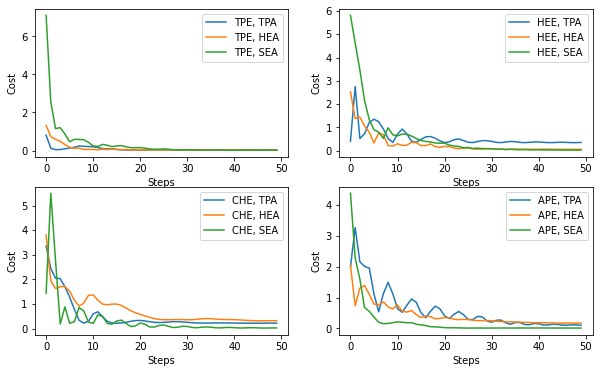

In [6]:
plot_cost(cost_all_iris)

In [7]:
sort_cost_acc(optimized_cost_acc_iris)

LOG
embedding_type: APE, ansatz_type: SEA: cost 0.013002758750095636
embedding_type: HEE, ansatz_type: SEA: cost 0.02106081428675735
embedding_type: TPE, ansatz_type: SEA: cost 0.021350397911644024
embedding_type: TPE, ansatz_type: TPA: cost 0.02322091764017143
embedding_type: TPE, ansatz_type: HEA: cost 0.025219271928122587
embedding_type: CHE, ansatz_type: SEA: cost 0.02869743530853825
embedding_type: HEE, ansatz_type: HEA: cost 0.052945295331292566
embedding_type: APE, ansatz_type: TPA: cost 0.10462691926852068
embedding_type: APE, ansatz_type: HEA: cost 0.17327776124011382
embedding_type: CHE, ansatz_type: TPA: cost 0.2224988457733549
embedding_type: CHE, ansatz_type: HEA: cost 0.3224629541812168
embedding_type: HEE, ansatz_type: TPA: cost 0.34993589339496306
---------------------------------------------------------------
embedding_type: CHE, ansatz_type: SEA: accuracy 1.0
embedding_type: TPE, ansatz_type: TPA: accuracy 0.95
embedding_type: TPE, ansatz_type: HEA: accuracy 0.95
embe